# Saving Data to External Files
This notebook gives examples of how to write out selected data from [`GBTFitsLoad`](https://dysh.readthedocs.io/en/latest/modules/dysh.fits.html#module-dysh.fits.gbtfitsload) and how to save 
[`Spectrum`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#module-dysh.spectra.spectrum), 
[`Scan`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#module-dysh.spectra.scan), and 
[`ScanBlock`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#dysh.spectra.scan.ScanBlock) to different formats.
It also introduces the 
[`dysh_data`](https://dysh.readthedocs.io/en/latest/modules/dysh.util,html) 
function to obtain filename references to various test and example data.

## Dysh Commands

The following dysh commands are introduced (leaving out all the function arguments):

    filename = dysh_data()
    sdf = GBTFITSLoad()
    sb = sdf.getps()
    ta = sb.timeaverage()
    ta.average()
    ta.plot()
    ta.write()
    Spectrum.read()

## Loading Modules
We start by loading the modules we will use for this example. 

For display purposes, we use the static (non-interactive) matplotlib backend in this tutorial. However, you can tell `matplotlib` to use the `ipympl` backend to enable interactive plots. This is only needed if working on jupyter lab or notebook.

In [1]:
# Set interactive plots in jupyter.
#%matplotlib ipympl

# These modules are required for loading and reading data.
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.spectra.spectrum import Spectrum
from astropy import units as u
from dysh.log import init_logging

# We will use matplotlib for plotting.
import matplotlib.pyplot as plt

# These modules are used for file I/O
from dysh.util.files import dysh_data
from pathlib import Path

## Setup
We start the dysh logging, so we get more information about what is happening.
This is only needed if working on a notebook.
If using the CLI through the ``dysh`` command, then logging is setup for you.

We also create a directory where output files from the notebook get stored.

In [2]:
init_logging(2)

# also create a local "output" directory where temporary notebook files can be stored.
output_dir = Path.cwd() / "output"
output_dir.mkdir(exist_ok=True)

## Data Retrieval

Download the example SDFITS data, if necessary.

The actual full path filename will depend on your dysh installation, it could be local, or it will need to be downloaded.

The [dysh_data](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.util.html#dysh.util.files.dysh_data)
function has a few mnemonics, to avoid having to remember long filenames. Data via `test=` are available for developers, since they come with the code. Data via `example=` will need to be downloaded, unless developers have downloaded the example data into `$DYSH_DATA/example_data`.

Here is an example how to find the aliases available with `test=`

In [3]:
dysh_data(test="?")

# dysh_data::test
# ---------------
getps AGBT05B_047_01/AGBT05B_047_01.raw.acs/
getps2 TGBT21A_501_11/TGBT21A_501_11.raw.vegas.fits
getfs TGBT21A_504_01/TGBT21A_504_01.raw.vegas/TGBT21A_504_01.raw.vegas.A.fits
subbeamnod2 TRCO_230413_Ka


For many example notebooks we use the `getps` dataset.   In the next cell there are multiple ways to get at the same data:

In [4]:
# filename = dysh_data(example="positionswitch/data/AGBT05B_047_01/AGBT05B_047_01.raw.acs/AGBT05B_047_01.raw.acs.fits")
# filename = dysh_data(example="getps")
filename = dysh_data(test="getps")

12:36:56.175 I Resolving test=getps -> AGBT05B_047_01/AGBT05B_047_01.raw.acs/


## Data Loading

Next, we use `GBTFITSLoad` to load the data, and report some basic `info` and use the `summary` method to inspect its contents.

In [5]:
sdfits = GBTFITSLoad(filename)
sdfits.info()

Filename: /home/teuben/GBT/dysh/testdata/AGBT05B_047_01/AGBT05B_047_01.raw.acs/AGBT05B_047_01.raw.acs.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SINGLE DISH    1 BinTableHDU    229   352R x 70C   ['32A', '1D', '22A', '1D', '1D', '1D', '32768E', '16A', '6A', '8A', '1D', '1D', '1D', '4A', '1D', '4A', '1D', '1I', '32A', '32A', '1J', '32A', '16A', '1E', '8A', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '8A', '1D', '1D', '12A', '1I', '1I', '1D', '1D', '1I', '1A', '1I', '1I', '16A', '16A', '1J', '1J', '22A', '1D', '1D', '1I', '1A', '1D', '1E', '1D', '1A', '1A', '8A', '1E', '1E', '16A', '1I', '1I', '1I']   


In [6]:
sdfits.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.3431,18.6427
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.9306,18.7872
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.3305,18.3561
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.9157,18.4927
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.3042,18.0575
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.8906,18.1860
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.3275,17.3853
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.9192,17.4949


### Calibrate a position switched scan.  

The `getps` function returns a `ScanBlock` containing one [`PSScan`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#dysh.spectra.scan.PSScan) with 11 integrations for the ON position and 11 integrations for the OFF position.

In [7]:
ps_scan_block = sdfits.getps(scan=51, ifnum=0, plnum=0, fdnum=0)

In [8]:
print(f"Number of integrations = {ps_scan_block[0].nrows}")

Number of integrations = 22


Get the time average of the calibrated data. This method returns a `Spectrum`.

In [9]:
ta = ps_scan_block.timeaverage()

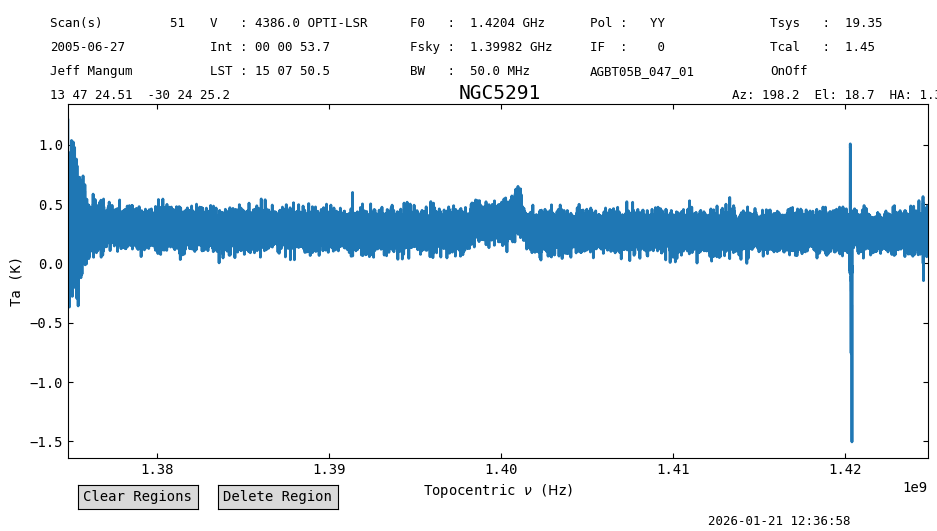

In [10]:
ta.plot()

In the *Position-Switched Data Reduction* notebook we will go in more depth on this particular data.   Here we continue with some examples how to write and read data.

## Reading and Writing Individual Spectra

###  Inputs and Outputs
`dysh` supports output to text files in a variety of [formats familiar to users of astropy](https://docs.astropy.org/en/stable/io/ascii/index.html#id1):
* basic
* commented_header
* ECSV
* fixed_width
* IPAC
* MRT
* votable

The following lines of code define some of the available formats in a list, and then loop over them saving the calibrated data in each format.
We use the `overwrite=True` parameter to avoid errors if the files already exist on disk.

In [11]:
# Define the formats in a list.
fmt = [ 
    "basic",
    "commented_header",
    "ecsv",
    "fixed_width",
    "ipac",
    "mrt",
    "votable",
]


# Loop over formats writing the calibrated spectrum.
for f in fmt:
    file = output_dir / f"testwrite.{f}"
    ta.write(file, format=f, overwrite=True)

We can also write a `Spectrum` to FITS format 

NOTE:  this is actually NOT the SDFITS format, but a BINTABLE erroneously labeled as "SINGLE DISH".

In [12]:
ta.write(output_dir / "testwrite.fits", format="fits", overwrite=True)

We can read spectra in FITS and a few formats. [As noted in astropy, ECSV ](https://docs.astropy.org/en/stable/io/ascii/ecsv.html#ecsv-format) is the only ASCII format that can make a lossless output-input roundtrip and thus reproduce an original spectrum.

We use the `Spectrum.read` method to read the saved data.

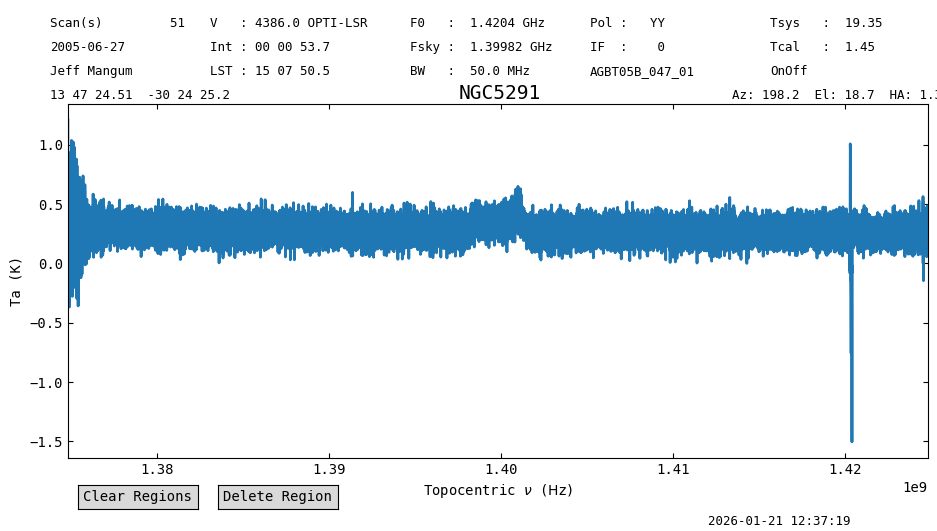

In [13]:
s1 = Spectrum.read(output_dir / "testwrite.fits", format="fits")
s1.plot()

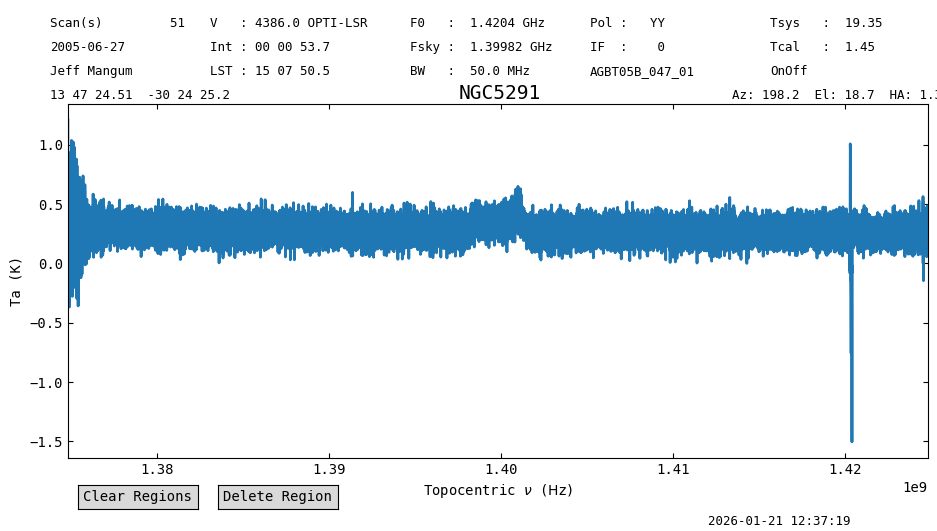

In [14]:
s2 = Spectrum.read(output_dir / "testwrite.ecsv", format="ecsv")
s2.plot()

### GBTIDL ASCII format
`dysh` can read text files created by GBTIDL's `write_ascii` function. However, those files do not provide sufficient metadata to fully recreate the spectrum.  (For instance, they do not have complete sky coordinate information, or 

In [15]:
# "https://www.gb.nrao.edu/dysh/example_data/onoff-L/gbtidl-data/onoff-L_gettp_156_intnum_0_HEL.ascii"
filename_ascii = dysh_data(example="onoff-L/gbtidl-data/onoff-L_gettp_156_intnum_0_HEL.ascii")
s3 = Spectrum.read(filename_ascii, format='gbtidl')

In [16]:
print(s3, "\n", s3.meta)

Spectrum (length=32768)
Flux=[3608710. 3553598. 3604808. ... 3523171. 3545982. 3474847.] ct,  mean=493422767.43425 ct
Spectral Axis=[1.42009237 1.42009166 1.42009094 ... 1.39665654 1.39665582
               1.39665511] GHz,  mean=1.40837 GHz 
 {'SCAN': 156, 'OBJECT': 'NGC2782', 'DATE-OBS': '2021-02-10 00:00:00.000', 'RA': 119.42083333333332, 'VELDEF': 'None-HEL', 'POL': 'YY'}


In [17]:
# @todo    fix the velocity frame for a plot to work
# s3.plot()

`dysh` can even read compressed ASCII files. Note these data have velocity on the spectral axis.

In [18]:
filename_ascii_gz = dysh_data(example="onoff-L/gbtidl-data/onoff-L_getps_152_RADI-HEL.ascii.gz")
s4 = Spectrum.read(filename_ascii_gz, format='gbtidl')

In [19]:
print(s4, "\n", s4.meta)

Spectrum (length=32768)
Flux=[-0.1042543   0.05250004  0.00432693 ... -0.05038555  0.03408394
       0.06139921] K,  mean=0.17345 K
Spectral Axis=[1281.15245599 1281.30342637 1281.45439674 ... 6227.69690405
               6227.84787443 6227.99884481] km / s,  mean=3754.57565 km / s 
 {'SCAN': 152, 'OBJECT': 'NGC2415', 'DATE-OBS': '2021-02-10 00:00:00.000', 'RA': 114.65624999999999, 'VELDEF': 'RADI-HEL', 'POL': 'YY'}


#### Plot 
To plot the spectrum contained in the ascii files you have to use `matplotlib`.

In [20]:
# set the rest frequency to the HI line
s4.rest_value = 1420405751.786 * u.Hz

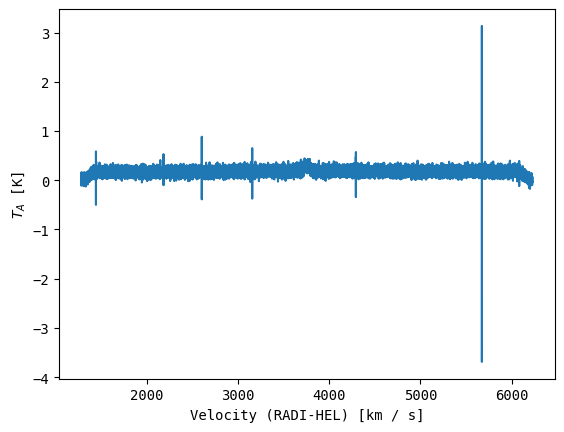

In [21]:
plt.figure()
plt.xlabel(f"Velocity ({s4.meta['VELDEF']}) [{s4.spectral_axis.unit}]")
plt.ylabel(f"$T_A$ [{s4.flux.unit}]")
plt.plot(s4.spectral_axis, s4.flux)

Apart from the signal around 3800 km/s, there are a handfull of positive-negative instrumental spikes That is for another notebook.

## Writing Multiple Calibrated Spectra to SDFITS
You can write the calibrated data from a `ScanBlock` to the SDFITS format.
If there are multiple scans in the `ScanBlock`, they will all be written to the same SDFITS (useful for `gbtgridder`).

In [22]:
ps_scan_block.write(output_dir / "scanblock.fits", overwrite=True)

## Reading Calibrated SDFITS

To load the saved data, we use the same function we used to load the raw data, `GBTFITSLoad`.

In [23]:
ps_scan_block_read = GBTFITSLoad(output_dir / "scanblock.fits")

This is treated the same was as the raw data, so the same methods are available.

In [24]:
ps_scan_block_read.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,1,11,1,198.3431,18.6427


However, since the data is already calibrated, trying to fetch the data using calibration methods like `getps` or `getnod` will result in errors.
Instead, we can use the `gettp` method or `getspec`.

### Using `gettp`

If we use `gettp`, then we will get all of the integrations as a `ScanBlock` object.

In [25]:
tp_read = ps_scan_block_read.gettp(scan=51, ifnum=0, plnum=0, fdnum=0)
print(f"Number of integrations: {tp_read[0].nint}")

12:37:20.731 I Using TSYS column


Number of integrations: 11


We can access individual integration through the `calibrated` method.

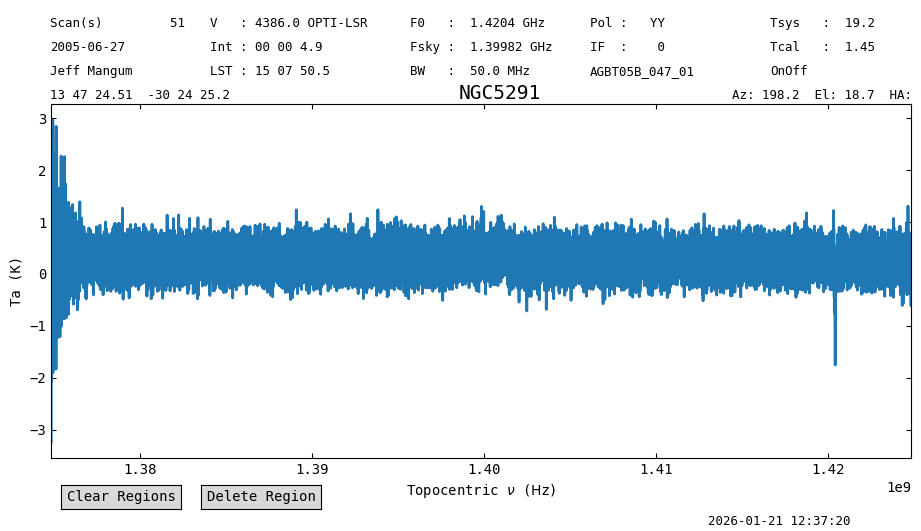

In [26]:
ta_read_0a = tp_read[0].getspec(0)
ta_read_0a.plot()

### Using `getspec`

Now we do the same using `getspec`. This method takes as input the row number we want to retrieve.

In [27]:
ta_read_0b = ps_scan_block_read.getspec(0)

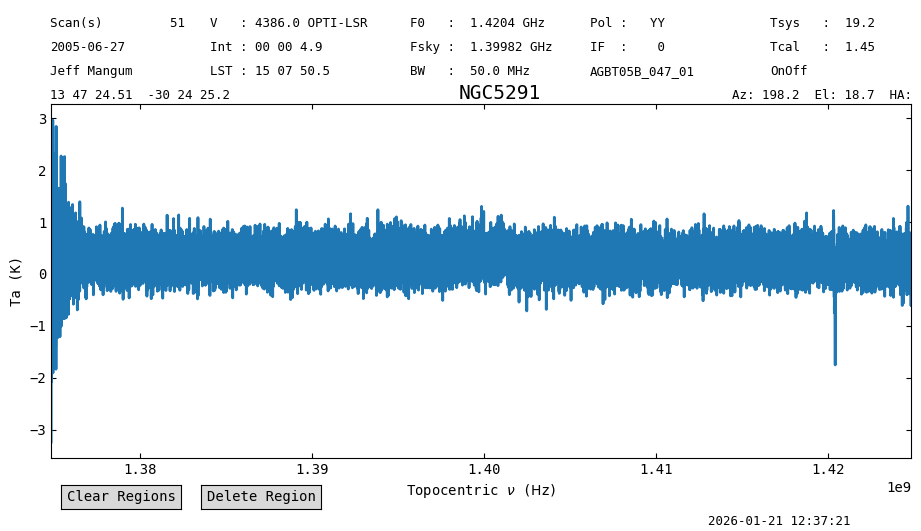

In [28]:
ta_read_0b.plot()

If we take the difference, it is zero.

In [29]:
(ta_read_0a.data - ta_read_0b.data).sum()

0.0

## Writing Out Selected Data from `GBTFITSLoad`
The `write()` method of `GBTFITSLoad` supports down-selection of data. 
Data can be selected on any SDFITS column.

In the following call to `GBTFITSLoad.write` we will select a single polarization (`plnum=1`), and only the first five integrations of each scan (`intnum=range(5)`). We also set `overwrite=True` to avoid errors if the file already exists, and request that the output be saved into a single file (`multifile=False`).

In [30]:
sdfits.write(output_dir / "mydata.fits", plnum=1, 
             intnum=range(5), overwrite=True, multifile=False)

 ID    TAG    PLNUM   INTNUM   # SELECTED
--- --------- ----- ---------- ----------
  0 59c23e6af     1 range(0,5)         80


These data, can of course, be read back in.

In [31]:
sdfits2 = GBTFITSLoad(output_dir / "mydata.fits")

In [32]:
sdfits2.summary()

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,1,5,1,198.2327,18.6739
52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,1,5,1,198.8200,18.8193
53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,1,5,1,199.2207,18.3889
54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,1,5,1,199.8058,18.5264
55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,1,5,1,200.1952,18.0919
56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,1,5,1,200.7815,18.2213
57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,1,5,1,202.2201,17.4228
58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,1,5,1,202.8117,17.5334


### Writing SDFITS to Multiple Files 
If the data came from multiple files, for instance VEGAS banks, then by default they are written to multiple files, so
```
   sdfits.write('mydata.fits')
```
would write to mydata0.fits, mydata1.fits, ... mydataN.fits.

If you want them organized for `GBTFITSLoad`, create a new directory first (and/or make sure this directory is clean):
```
   import os
   os.mkdir("my")
   sdfits.write("my/data.fits")
```
which would write my/data0.fits, my/data1.fits, ... my/dataN.fits. This way `GBTFITSLoad` can more easily read them as a related group:
```
   mysdf = GBTFITSLoad("my")
```



## Final Stats

Finally, at the end we compute some statistics over a spectrum, merely as a checksum if the notebook is reproducable.


In [33]:
ta_read_0a.stats()  # rms 0.26165166 K

{'mean': <Quantity 0.27980035 K>,
 'median': <Quantity 0.27948517 K>,
 'rms': <Quantity 0.26165166 K>,
 'min': <Quantity -3.23166323 K>,
 'max': <Quantity 2.96101713 K>,
 'npt': 32768,
 'nan': 0}